# GEM5 ARM

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

### vars

In [2]:
#gem5Path = '/home/anton/Master/tools/gem5/gem5-Arm/' 
#build = 'build/X86/gem5.opt'
gem5Path = '/home/fft_vec/gem5/'
build = 'build/ARM/gem5.opt'

gem5 = gem5Path + build

baseDir = './bench/'  + build.replace('.', '-').replace('/','-') + '/'

In [3]:
config = gem5Path + 'configs/example/se.py'

In [4]:
defultOption = "--cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches"
defultOption = "--cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches"

In [50]:
darknet = './darknet'
#yolo = 'bench_yolo-20l'
#yolo = 'bench_yolo'
yolo = 'bench_yolo-tiny'
#vgg = 'todo' 
#darknet19 = 'bench_darknet19'
#test = ""

In [6]:
armCompileOptions = 'CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++' 

In [7]:
class Program(Enum):
    BASELINE = 0
    NNPACK_FT8 = 1
    NO_PREDICT = 2
    NO_PREDICT_NPP = 3
    NNPACK_GEMM = 4
    NNPACK_FT16 = 5
    NNPACK_WT = 6

## utils

In [39]:
def make(program):
    
    values = ""
    
    match program:
        case Program.BASELINE: values = 'NNPACK=0'        
        case Program.NNPACK_FT8:   values = 'NNPACK=1 FT8=1'
        case Program.NNPACK_FT16:   values = 'NNPACK=1 FT16=1'
        case Program.NNPACK_WT:   values = 'NNPACK=1 WT=1'
        case Program.NNPACK_GEMM: values = 'NNPACK=1 GEMM=1' 
        case Program.NO_PREDICT_NPP: values = 'NNPACK=1 PREDICT=0 FT8=1' 
        case Program.NO_PREDICT: values = 'NNPACK=0 PREDICT=0' 
        
    cmd = 'make clean; make'+ ' ' + values + ' ' + armCompileOptions
    print('\n',cmd,'\n')
    os.system(cmd) 

In [9]:
def optionsToSubDir(benchmark, program, tag):
    
    if benchmark == '':
        benchmark = 'NAN' 
    
    programStr = 'NAN'
    
    match program:
        case Program.BASELINE: programStr = 'BASELINE'        
        case Program.NNPACK_FT8:   programStr = 'FT8'
        case Program.NNPACK_FT16:   programStr = 'FT16'
        case Program.NNPACK_WT:   programStr = 'WT'
        case Program.NNPACK_GEMM: programStr = 'GEMM' 
        case Program.NO_PREDICT_NPP: programStr = 'NO_PREDICT_NPP' 
        case Program.NO_PREDICT: programStr = 'NO_PREDICT' 

    path = '/'.join([benchmark,programStr,tag]) + '/'
    
    return path

In [10]:
def cyclesToSetup(program,option,benchmark_to_run,tag):
    make(program);
    out = bench(benchmark_to_run,option,program, tag)
    print(out)
    #data=[]
    data = readData([out])[0]
    print(data)
    return (out, data)

def cyclesOptions(program,options,benchmark_to_run,tags):  
    data = []
    out = []
    for i in range(len(options)):
        result = cyclesToSetup(program,options[i],benchmark_to_run,tags[i])
        data.append(result[0])
        out.append(result[1])
        
    return (out,data)
    

#def cyclesToSetup_baseline(benchmark_to_run):
#    return cyclesToSetup(Program.NO_PREDICT,benchmark_to_run,'setup_baseline')

def cyclesToSetup_npp(benchmark_to_run,options,tags):
    return cyclesOptions(Program.NO_PREDICT_NPP,options,benchmark_to_run,tags)

In [11]:
def readData(Dirs):
    data = []
    names = ['simTicks']
    for Dir in Dirs: 
    
        result = []
    
        file = Dir+'stats.txt'
        print("reading data from file: ",file,"\n ")
        with open(file, 'r') as fp:
            lines = fp.readlines()
            for row in lines:
                for name in names:
                    if row.find(name) == 0:
                        value = int(row.split()[1])
                        result.append((name,value))
    
        data.append(result)                
        
    return data

In [12]:
def bench(benchmark, options, program, tag):

    outDir =  baseDir + optionsToSubDir(benchmark, program, tag)
    out = '--outdir='+ outDir
    
    binary = '-c ' + '"'+ darknet  + '"' + ' --options ' + '"' + benchmark + '"'
    
    cmd = ' '.join([gem5,out,config,defultOption,'--output=stdout.txt  --errout=stderr.txt',options,binary])
   
    print(cmd + '\n\n')
    
    os.system(cmd)
    
    return(outDir)

In [13]:
def run_benchmark(benchmark, options, nnpack, tag):
    out = bench(benchmark, options, nnpack, tag)
    return(out)

In [14]:
def benchOptions(benchmark, optionsList, program, tags):
    
    n = len(optionsList)
    
    out = [None] * n
    
    for i in range(n):
        out[i] = run_benchmark(benchmark, optionsList[i], program, tags[i])
        
    return(out)

In [15]:
def benchOptionsMatrix(benchmark, options1, options2, nnpack, tags1, tags2): #to bench vector and l2 chace
    options =[opt1 + ' ' + opt2 for opt1 in options1 for opt2 in options2]
    tags = [tag1 + '_' + tag2 for tag1 in tags1 for tag2 in tags2]
    
    out = benchOptions(benchmark, options, nnpack, tags) 
    return(out)

### util graphs

In [16]:
def plotChaceVsCycle(chaces,data, setupcosts):
    cycles=[]
    print("hej--..: ", setupcosts)
    print("då--..: ", data)
    for i in range(len(data)):
        cycles.append(data[i][0][1] - setupcosts[i][0][1])
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    print(cycles)
    print(chaces)
    ax.bar(chaces,cycles)
    plt.show()
    
    

In [17]:
def runandPlot(program,benchmark_to_run ,options, tags, setup_costs ):
    make(program)
    out = benchOptions(benchmark_to_run,options,program,tags)
    print(out)
    
    data = readData(out)
    print(data)
    print(setup_costs)
    
    plotChaceVsCycle(tags[::-1],data[::-1], setup_costs[0][::-1])
    return(out,data)
    

In [18]:
def readandplot(dirs,x_line,setupticks):
    y_line = readData(dirs)
    ms = readData(setupticks[1])
    plotChaceVsCycle(x_line,y_line, ms)
    

# X86 YOLO and L2 chace

In [19]:
#yolo = ''

In [30]:
chaceSizes = ['256MB','64MB','8MB','1MB']
chaceSizes = ['256MB','64MB','8MB']
chaceOptions = ['--l2_size=' + size + ' --l2cache' for size in chaceSizes]
chaceOptions

['--l2_size=256MB --l2cache',
 '--l2_size=64MB --l2cache',
 '--l2_size=8MB --l2cache']

In [51]:
setupnppticks_npp = cyclesToSetup_npp(yolo, chaceOptions,chaceSizes)
setupnppticks_npp 


 make clean; make NNPACK=1 PREDICT=0 FT8=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.s

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:597:16: warning: unused variable ‘X’ [-Wunused-variable]
  597 |         float *X = sized.data;
      |                ^


aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/test.c -o obj/test.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti' unimplemented
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 14:11:43
gem5 executing on aldy, pid 2065228
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/256MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options bench_yolo-20l

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 310389858000 because exiting with last active thread context
./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/256MB/
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/256MB/stats.txt 
 
[('simTicks', 310389858000)]

 make clean; make NNPACK=1 PREDICT=0 FT8=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activa

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:597:16: warning: unused variable ‘X’ [-Wunused-variable]
  597 |         float *X = sized.data;
      |                ^


aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/test.c -o obj/test.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 14:15:47
gem5 executing on aldy, pid 2079500
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options bench_yolo-20l

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 310389852500 because exiting with last active thread context
./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/64MB/
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/64MB/stats.txt 
 
[('simTicks', 310389852500)]

 make clean; make NNPACK=1 PREDICT=0 FT8=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activati

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:597:16: warning: unused variable ‘X’ [-Wunused-variable]
  597 |         float *X = sized.data;
      |                ^


aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/test.c -o obj/test.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 14:19:51
gem5 executing on aldy, pid 2093928
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options bench_yolo-20l

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 310389847000 because exiting with last active thread context
./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/8MB/
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/8MB/stats.txt 
 
[('simTicks', 310389847000)]


([[('simTicks', 310389858000)],
  [('simTicks', 310389852500)],
  [('simTicks', 310389847000)]],
 ['./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/256MB/',
  './bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/64MB/',
  './bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/8MB/'])

([[('simTicks', 2614375470500)],
  [('simTicks', 2614375465000)],
  [('simTicks', 2614375459500)]],
 ['./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/',
  './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/',
  './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/'])

# FT8


 make clean; make NNPACK=1 FT8=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarkn

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti' unimplemented
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 13 2023 19:06:24
gem5 executing on aldy, pid 3603242
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/256MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 2614375470500 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=64MB --l2cache -c "./darknet" --options "bench_yolo-tiny"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 13 2023 19:41:00
gem5 executing on aldy, pid 3664436
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 2614375465000 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=8MB --l2cache -c "./darknet" --options "bench_yolo-tiny"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 13 2023 20:15:32
gem5 executing on aldy, pid 3725029
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 2614375459500 because exiting with last active thread context
['./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/8MB/']
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/8MB/stats.txt 
 
[[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]]
([[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]], ['./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/'])
hej--..:  [[('simTicks', 2614375459500)], [('simTicks', 2614375465000)], [('simTicks', 2614

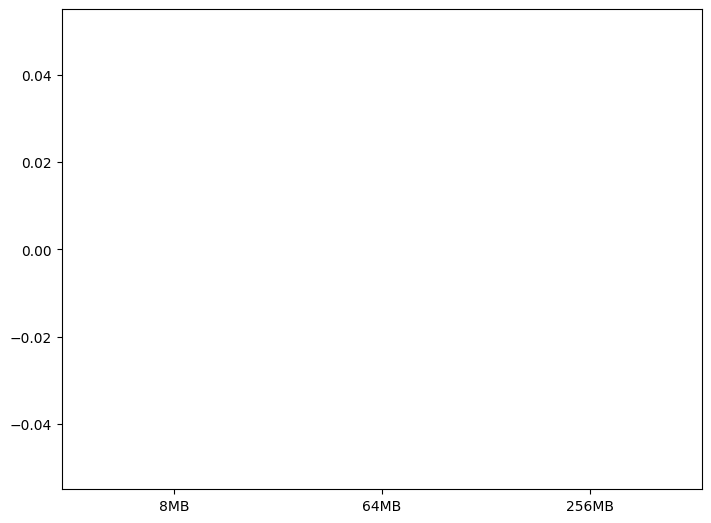

In [31]:
ft8Result = runandPlot(Program.NNPACK_FT8,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT8/8MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/stats.txt 
 
hej--..:  [[('simTicks', 1191116040500)], [('simTicks', 1191116035000)], [('simTicks', 1191116029500)]]
då--..:  [[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]]
[1423259430000, 1423259430000, 1423259430000]
['256MB', '64MB', '8MB']


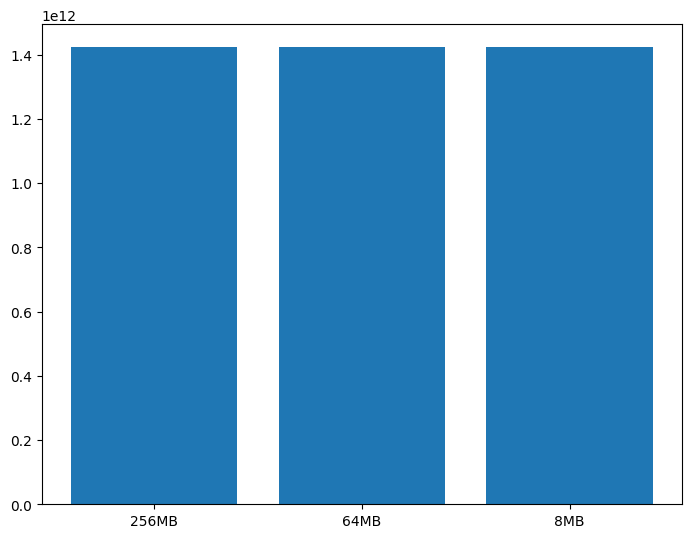

In [44]:
readandplot(ft8Result[0],chaceSizes,setupnppticks_npp)

# WT


 make clean; make NNPACK=1 WT=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarkne

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti' unimplemented
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 13 2023 20:50:20
gem5 executing on aldy, pid 3786322
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/256MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 2614375470500 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=64MB --l2cache -c "./darknet" --options "bench_yolo-tiny"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 13 2023 21:24:56
gem5 executing on aldy, pid 3847084
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 2614375465000 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=8MB --l2cache -c "./darknet" --options "bench_yolo-tiny"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 13 2023 21:59:38
gem5 executing on aldy, pid 3908004
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 2614375459500 because exiting with last active thread context
['./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/8MB/']
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/8MB/stats.txt 
 
[[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]]
([[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]], ['./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/'])
hej--..:  [[('simTicks', 2614375459500)], [('simTicks', 2614375465000)], [('simTicks', 2614375470

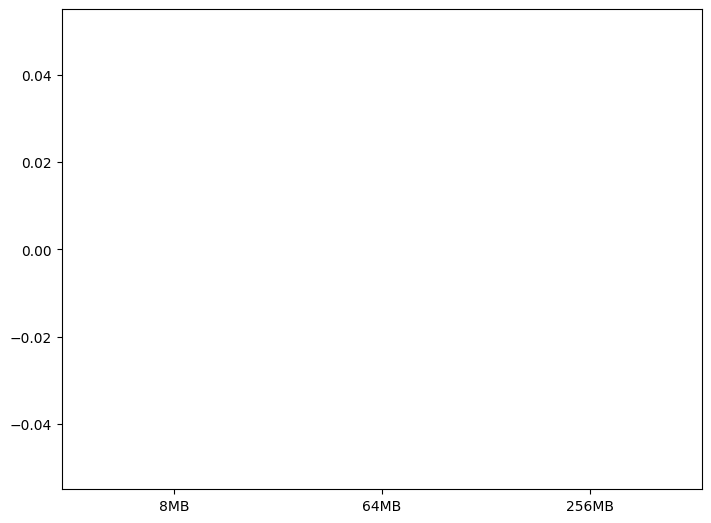

In [33]:
wtResult = runandPlot(Program.NNPACK_WT,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/WT/8MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/stats.txt 
 
hej--..:  [[('simTicks', 1191116040500)], [('simTicks', 1191116035000)], [('simTicks', 1191116029500)]]
då--..:  [[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]]
[1423259430000, 1423259430000, 1423259430000]
['256MB', '64MB', '8MB']


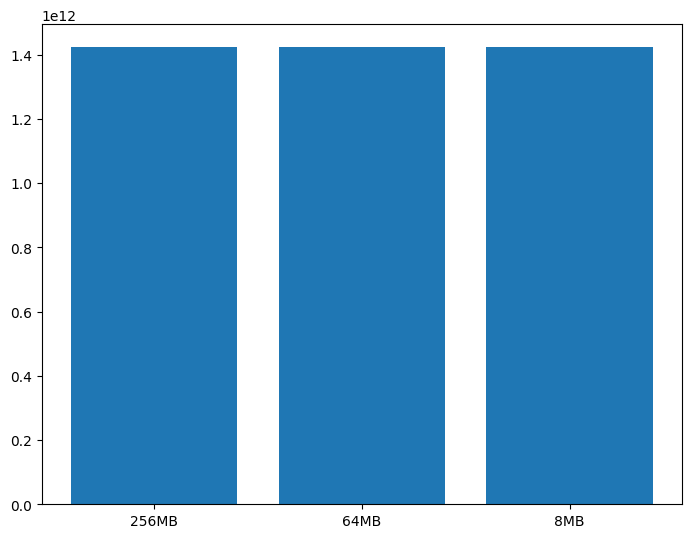

In [43]:
readandplot(wtResult[0],chaceSizes,setupnppticks_npp)

# FT16


 make clean; make NNPACK=1 FT16=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdark

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:597:16: warning: unused variable ‘X’ [-Wunused-variable]
  597 |         float *X = sized.data;
      |                ^


aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/test.c -o obj/test.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti' unimplemented
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 00:18:42
gem5 executing on aldy, pid 4152404
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/256MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 1191116040500 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=64MB --l2cache -c "./darknet" --options "bench_yolo-tiny"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 00:33:32
gem5 executing on aldy, pid 4178396
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 1191116035000 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=8MB --l2cache -c "./darknet" --options "bench_yolo-tiny"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 00:48:31
gem5 executing on aldy, pid 11117
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options bench_yolo-tiny

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 1191116029500 because exiting with last active thread context
['./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/8MB/']
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/8MB/stats.txt 
 
[[('simTicks', 1191116040500)], [('simTicks', 1191116035000)], [('simTicks', 1191116029500)]]
([[('simTicks', 2614375470500)], [('simTicks', 2614375465000)], [('simTicks', 2614375459500)]], ['./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/'])
hej--..:  [[('simTicks', 2614375459500)], [('simTicks', 2614375465000)], [('simTicks'

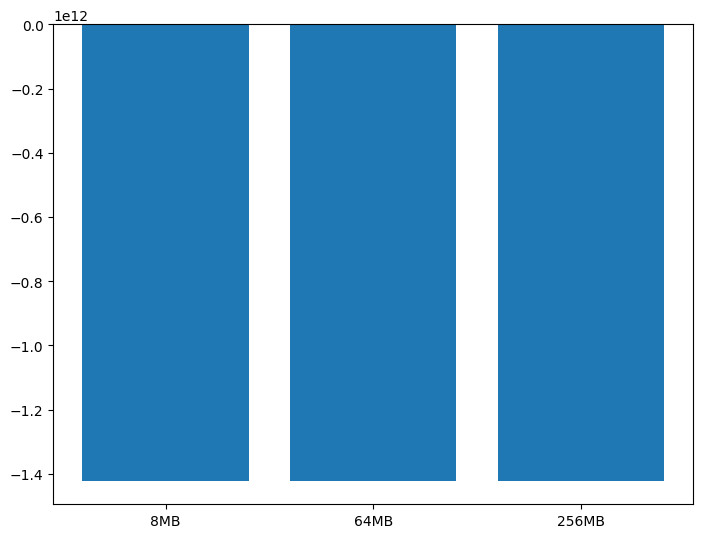

In [37]:
ft16Result = runandPlot(Program.NNPACK_FT16,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/FT16/8MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-tiny/NO_PREDICT_NPP/8MB/stats.txt 
 
hej--..:  [[('simTicks', 1191116040500)], [('simTicks', 1191116035000)], [('simTicks', 1191116029500)]]
då--..:  [[('simTicks', 1191116040500)], [('simTicks', 1191116035000)], [('simTicks', 1191116029500)]]
[0, 0, 0]
['256MB', '64MB', '8MB']


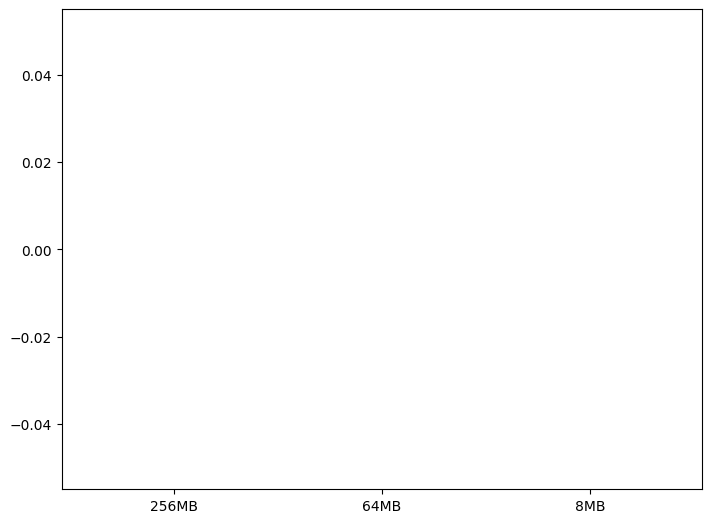

In [42]:
readandplot(ft16Result[0],chaceSizes,setupnppticks_npp)

## baseline

In [ ]:
#setupticks = cyclesToSetup_baseline(yolo)
#setupticks

In [ ]:
#baslineResult = runandPlot(Program.BASELINE,yolo ,chaceOptions, chaceSizes, setupticks)

In [ ]:
#readandplot(baslineResult[0],chaceSizes,setupticks)

# GEMM


 make clean; make NNPACK=1 GEMM=1 CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++ 

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdark

In function ‘copy_string’,
    inlined from ‘basecfg’ at ./src/utils.c:187:9:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘basecfg’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  426 |     strncpy(copy, s, strlen(s)+1);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
In function ‘copy_string’,
    inlined from ‘parse_csv_line’ at ./src/utils.c:439:28:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the lengt

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/cuda.c -o obj/cuda.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/list.c -o obj/list.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./src/image.c -o obj/image.o
aarch64-none-linux-gnu-gcc -Iinclu

aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/lsd.c -o obj/lsd.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/super.c -o obj/super.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/art.c -o obj/art.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/tag.c -o obj/tag.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/cifar.c -o obj/cifar.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-un

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:597:16: warning: unused variable ‘X’ [-Wunused-variable]
  597 |         float *X = sized.data;
      |                ^


aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK -c ./examples/test.c -o obj/test.o
aarch64-none-linux-gnu-gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -fno-tree-vectorize -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti' unimplemented
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 14:23:54
gem5 executing on aldy, pid 2108266
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/256MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options bench_yolo-20l

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 310389858000 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=64MB --l2cache -c "./darknet" --options "bench_yolo-20l"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 14:27:46
gem5 executing on aldy, pid 2121752
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/64MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options bench_yolo-20l

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 310389852500 because exiting with last active thread context
/home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=8MB --l2cache -c "./darknet" --options "bench_yolo-20l"




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: No dot file generated. Please install pydot to generate the dot file and pdf.
build/ARM/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/ARM/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/ARM/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:74: warn: ignoring syscall rt_sigaction(...)
build/ARM/sim/syscall_emul.cc:85: warn: ignoring syscall rt_sigprocmask(...)
      (further warnings will be suppressed)
build/ARM/arch/arm/insts/pseudo.cc:172: warn: 	instruction 'bti

Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 26 2023 15:06:33
gem5 started Feb 14 2023 14:31:37
gem5 executing on aldy, pid 2135196
command line: /home/fft_vec/gem5/build/ARM/gem5.opt --outdir=./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/8MB/ /home/fft_vec/gem5/configs/example/se.py --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options bench_yolo-20l

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/ARM/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 310389847000 because exiting with last active thread context
['./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/8MB/']
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/8MB/stats.txt 
 
[[('simTicks', 310389858000)], [('simTicks', 310389852500)], [('simTicks', 310389847000)]]
([[('simTicks', 310389858000)], [('simTicks', 310389852500)], [('simTicks', 310389847000)]], ['./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/256MB/', './bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/64MB/', './bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/8MB/'])
hej--..:  [[('simTicks', 310389847000)], [('simTicks', 310389852500)], [('simTicks', 310389858000)]]


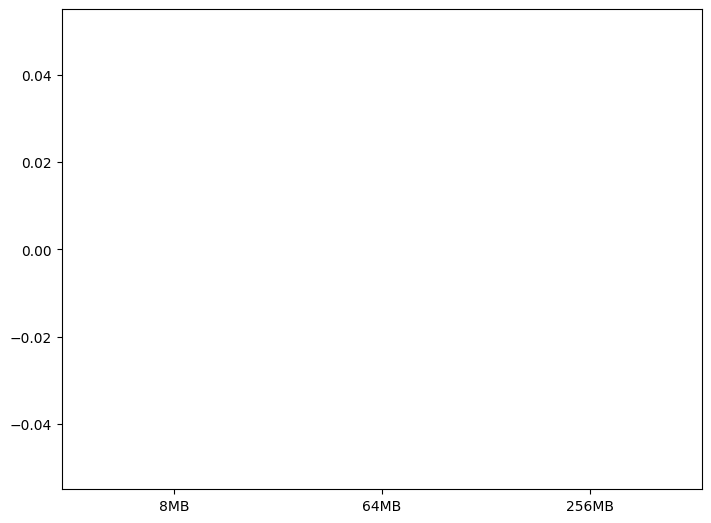

In [52]:
gemmResult = runandPlot(Program.NNPACK_GEMM,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/GEMM/8MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/256MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/64MB/stats.txt 
 
reading data from file:  ./bench/build-ARM-gem5-opt/bench_yolo-20l/NO_PREDICT_NPP/8MB/stats.txt 
 
hej--..:  [[('simTicks', 310389858000)], [('simTicks', 310389852500)], [('simTicks', 310389847000)]]
då--..:  [[('simTicks', 310389858000)], [('simTicks', 310389852500)], [('simTicks', 310389847000)]]
[0, 0, 0]
['256MB', '64MB', '8MB']


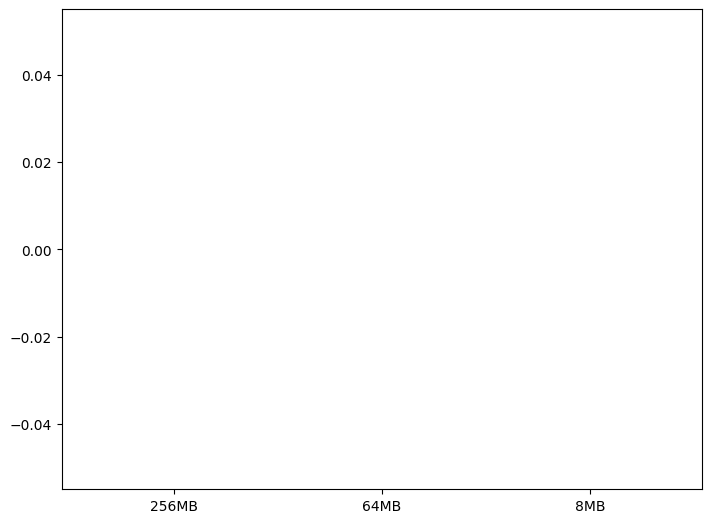

In [53]:
readandplot(gemmResult[0],chaceSizes,setupnppticks_npp)

In [28]:
LIST=[1,2,3,4]
LIST[0:3:1]

[1, 2, 3]